In [49]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [52]:
import matplotlib.pyplot as plt

In [53]:
import numpy as np
import os
import pyathena.rst_handler as rh

# Restart Handler example 

In [55]:
# reading a low-resolution restart dump
f_lowres = '/tigress/changgoo/R8_16pc_newacc/rst/R8_16pc_newacc.0010.rst'

In [72]:
# read-in one restart dump
fm,data=rh.read_rst_grid(f_lowres,verbose=True)
ns=0
for f in fm:
    if f.startswith('SCALAR'): ns+=1
print('nscalars:',ns)

N_STEP (125752,)
TIME (357.1457433072851,)
TIME_STEP (0.004745508126765593, 0.004523468296144703)
DENSITY 0.0010076195144813108 (32, 32, 32)
1-MOMENTUM 0.011632687079716073 (32, 32, 32)
2-MOMENTUM 0.010822001507803273 (32, 32, 32)
3-MOMENTUM 0.003158596551621191 (32, 32, 32)
ENERGY 0.40734542600235374 (32, 32, 32)
POTENTIAL -110.07563601761808 (32, 32, 32)
1-FIELD -0.048561498165411776 (32, 32, 33)
2-FIELD 0.0522314055208133 (32, 33, 32)
3-FIELD 0.06095655035947419 (33, 32, 32)
SCALAR 0 2.6628711640941762e-05 (32, 32, 32)
SCALAR 1 4.843212505200346e-06 (32, 32, 32)
SCALAR 2 2.353167319342957e-06 (32, 32, 32)
STAR PARTICLE LIST 393
{'id': (8634,), 'merge_history': (8436,), 'isnew': (0,), 'active': (-1,), 'm': (0.0,), 'x1': (-300.72756854148486,), 'x2': (-328.81298537503494,), 'x3': (2794.0003038139025,), 'v1': (-94.42483117506588,), 'v2': (-51.79035376276114,), 'v3': (79.7110181025656,), 'age': (-8.48732409570615,), 'mage': (32.36521356033229,), 'mdot': (0.0,), 'x1_old': (-300.300440811

# Merged Restart Data

In [57]:
# retrieving the Domain and Grid information from restart dump
par=rh.parse_par(f_lowres)
dm=par['domain1']
Nx=np.array([dm['Nx1'],dm['Nx2'],dm['Nx3']])
Ng=np.array([dm['NGrid_x1'],dm['NGrid_x2'],dm['NGrid_x3']])
Nb=Nx/Ng

In [62]:
# setting Grids: restriction -- each grid has to be in the same shape
grids,NG=rh.calculate_grid(Nx,Nb)

Domain Size: [ 64  64 448]
Grid Size: [32. 32. 32.]
Processor configuration: [ 2  2 14]
Number of Processors: 56


In [59]:
rstdata_low=rh.read(f_lowres,grids,NG,verbose=True)

[448  64  64] 56
N_STEP (125752,)
TIME (357.1457433072851,)
TIME_STEP (0.004745508126765593, 0.004523468296144703)
DENSITY 0.0010076195144813108 (32, 32, 32)
1-MOMENTUM 0.011632687079716073 (32, 32, 32)
2-MOMENTUM 0.010822001507803273 (32, 32, 32)
3-MOMENTUM 0.003158596551621191 (32, 32, 32)
ENERGY 0.40734542600235374 (32, 32, 32)
POTENTIAL -110.07563601761808 (32, 32, 32)
1-FIELD -0.048561498165411776 (32, 32, 33)
2-FIELD 0.0522314055208133 (32, 33, 32)
3-FIELD 0.06095655035947419 (33, 32, 32)
SCALAR 0 2.6628711640941762e-05 (32, 32, 32)
SCALAR 1 4.843212505200346e-06 (32, 32, 32)
SCALAR 2 2.353167319342957e-06 (32, 32, 32)
STAR PARTICLE LIST 393
{'id': (8634,), 'merge_history': (8436,), 'isnew': (0,), 'active': (-1,), 'm': (0.0,), 'x1': (-300.72756854148486,), 'x2': (-328.81298537503494,), 'x3': (2794.0003038139025,), 'v1': (-94.42483117506588,), 'v2': (-51.79035376276114,), 'v3': (79.7110181025656,), 'age': (-8.48732409570615,), 'mage': (32.36521356033229,), 'mdot': (0.0,), 'x1_old'

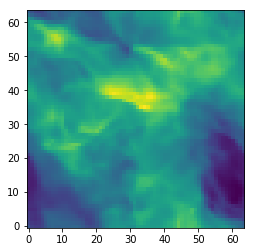

In [60]:
from matplotlib.colors import LogNorm
den=rstdata_low['DENSITY']
plt.imshow(den.mean(axis=0),norm=LogNorm(),origin='lower')

2.8331578528801183e-10 8.400096667504432e-19


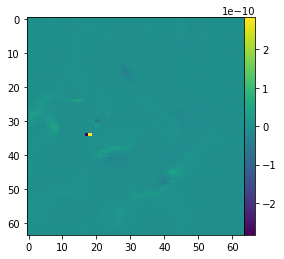

In [61]:
# check divB constraint
if '1-FIELD' in rstdata_low:
    divB=rh.divB(rstdata_low)
    print(divB.max(), divB.mean())
    k,j,i=np.unravel_index(np.argmax(divB),divB.shape)
    plt.imshow(divB[k,:,:])
    plt.colorbar(pad=0)

# Split-and-Save

In [41]:
# to run with more/less processors
Nb_new=np.array([64,64,64])

In [65]:
# recalculate Grid informtion from new Grid size
new_grids,NG=rh.calculate_grid(Nx,Nb_new)

Domain Size: [ 64  64 448]
Grid Size: [64 64 64]
Processor configuration: [1 1 7]
Number of Processors: 7


In [64]:
# read-in other information (star particles, user data) -- this is stored in all restart files
pardata_low=rh.parse_misc_info(f_lowres)

In [74]:
# writing SCALARS can be optional
rh.write_allfile(pardata_low,rstdata_low,new_grids,
                 dname='./rst/',id='test',itime=0,verbose=True,scalar=ns)

In [75]:
!ls ./rst

test.0000.rst	   test-id2.0000.rst  test-id4.0000.rst  test-id6.0000.rst
test-id1.0000.rst  test-id3.0000.rst  test-id5.0000.rst


# Refine-and-Save

In [78]:
# recalculate grid with new domain and gird size
grids_refine,NG_refine=rh.calculate_grid(Nx*2,[64,64,64])

Domain Size: [128 128 896]
Grid Size: [64, 64, 64]
Processor configuration: [ 2  2 14]
Number of Processors: 56


In [80]:
# refine data: no actual refinement, simply doubled number of zones
rstdata_refine=rh.refine(rstdata_low,scalar=ns)

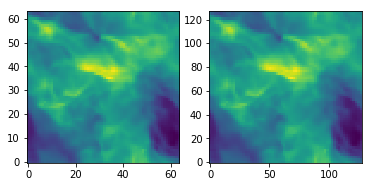

In [84]:
from matplotlib.colors import LogNorm
den=rstdata_low['DENSITY']
plt.subplot(1,2,1)
plt.imshow(den.mean(axis=0),norm=LogNorm(),origin='lower')
den=rstdata_refine['DENSITY']
plt.subplot(1,2,2)
plt.imshow(den.mean(axis=0),norm=LogNorm(),origin='lower')

1.416578926643347e-10 4.1000638482931353e-19


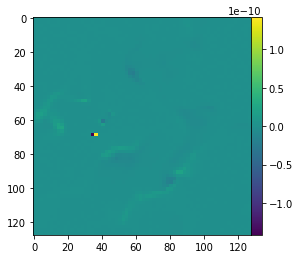

In [85]:
# check divB constraint
if '1-FIELD' in rstdata_refine:
    divB=rh.divB(rstdata_refine)
    print(divB.max(), divB.mean())
    k,j,i=np.unravel_index(np.argmax(divB),divB.shape)
    plt.imshow(divB[k,:,:])
    plt.colorbar(pad=0)

In [86]:
# writing SCALARS can be optional
rh.write_allfile(pardata_low,rstdata_refine,grids_refine,
                 dname='./rst/',id='test',itime=0,verbose=True,scalar=ns)

In [87]:
!ls ./rst

test.0000.rst	    test-id21.0000.rst	test-id34.0000.rst  test-id47.0000.rst
test-id10.0000.rst  test-id22.0000.rst	test-id35.0000.rst  test-id48.0000.rst
test-id1.0000.rst   test-id23.0000.rst	test-id36.0000.rst  test-id49.0000.rst
test-id11.0000.rst  test-id24.0000.rst	test-id37.0000.rst  test-id50.0000.rst
test-id12.0000.rst  test-id25.0000.rst	test-id38.0000.rst  test-id5.0000.rst
test-id13.0000.rst  test-id26.0000.rst	test-id39.0000.rst  test-id51.0000.rst
test-id14.0000.rst  test-id27.0000.rst	test-id40.0000.rst  test-id52.0000.rst
test-id15.0000.rst  test-id28.0000.rst	test-id4.0000.rst   test-id53.0000.rst
test-id16.0000.rst  test-id29.0000.rst	test-id41.0000.rst  test-id54.0000.rst
test-id17.0000.rst  test-id30.0000.rst	test-id42.0000.rst  test-id55.0000.rst
test-id18.0000.rst  test-id3.0000.rst	test-id43.0000.rst  test-id6.0000.rst
test-id19.0000.rst  test-id31.0000.rst	test-id44.0000.rst  test-id7.0000.rst
test-id20.0000.rst  test-id32.0000.rst	test-id45.0000.rst  test-id8.00

# CAUTION: you should correctly modify the parameter part in the restart file (e.b., Nx?, NGrid_x?)

### You can modify `pardata` before pass through `write_allfile` as follows. But, you have to check!

In [274]:
# par=pardata['par']
# par=par.replace('Nx1           = %d' % Nx[0],'Nx1           = %d' % (Nx[0]*2))
# par=par.replace('Nx2           = %d' % Nx[1],'Nx2           = %d' % (Nx[1]*2))
# par=par.replace('Nx3           = %d' % Nx[2],'Nx3           = %d' % (Nx[2]*2))
# par=par.replace('NGrid_x1      = %d' % NG[0],'NGrid_x1      = %d' % NG_refine[0])
# par=par.replace('NGrid_x2      = %d' % NG[1],'NGrid_x2      = %d' % NG_refine[1])
# par=par.replace('NGrid_x3      = %d' % NG[2],'NGrid_x3      = %d' % NG_refine[2])
# par=par.replace('AutoWithNProc = %d' % NG[0]*NG[1]*NG[2],'AutoWithNProc = 0')
# pardata['par']=par

# If the file is too big to read in the entire restart data for split or refine, you can use `refine_rst.py` 